# Import Dependencies

In [1]:
import numpy as np
import h5py
import cv2
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
import io
from tqdm import tqdm
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gc

import random
from random import randint

import torch
from torch.cuda.amp import GradScaler
from collections import OrderedDict
from scipy.interpolate import griddata
from tqdm.notebook import tqdm

# Data Loading

In [2]:
# Read
f_vort = h5py.File('/storage/p2/parfenyev/PINN/alpha_0.1/vort-prod.h5', 'r')
f_velx = h5py.File('/storage/p2/parfenyev/PINN/alpha_0.1/vel-u-prod.h5', 'r')
f_vely = h5py.File('/storage/p2/parfenyev/PINN/alpha_0.1/vel-v-prod.h5', 'r')
f_p = h5py.File('/storage/p2/parfenyev/PINN/alpha_0.1/p-prod.h5', 'r')

In [3]:
%%time
dat_vort = np.array(f_vort['vorticity'])
dat_velx = np.array(f_velx['vel-u'])
dat_vely = np.array(f_vely['vel-v'])
dat_p = np.array(f_p['p'])

CPU times: user 78.1 ms, sys: 557 ms, total: 635 ms
Wall time: 999 ms


# Data Visualization

In [ ]:
def save_video(arr, path, extent=[-np.pi, np.pi, -np.pi, np.pi], title=None, xy=None, w=None, h=None, limit=None):
    
    # Find correct framesize
    buf = io.BytesIO()
    plt.imshow(arr[:, :, 0])
    plt.savefig(buf, format="png")
    buf.seek(0)
    im = Image.open(buf)
    video = cv2.VideoWriter(path, cv2.VideoWriter_fourcc(*"mp4v"), 30, (im.size[0], im.size[1]))
    
    # Make a video
    for i in tqdm(range(arr.shape[2])):
        fig, ax = plt.subplots()
        buf = io.BytesIO()
        # extent [horizontal_min,horizontal_max,vertical_min,vertical_max]
        img = ax.imshow(arr[:, :, i], cmap="seismic", origin="lower", extent=extent, vmin=-50, vmax=50)
        fig.colorbar(img)
        if title:
            ax.set_title(title)
        if xy and w and h:
            rect = Rectangle(xy, w, h, linewidth=0, edgecolor='none', facecolor='r')
            ax.add_patch(rect)
        plt.savefig(buf, format="png")
        buf.seek(0)
        im = Image.open(buf)
        mat = np.array(im)
        mat = cv2.cvtColor(mat, cv2.COLOR_RGB2BGR)
        video.write(mat)
        buf.close()
        ax.cla()
        plt.clf()
        plt.close(fig)
        if i == limit:
            break
            
    plt.close()
    video.release()
    gc.collect()

In [ ]:
save_video(dat_vort, "./vort_long.mp4", title="vorticity")

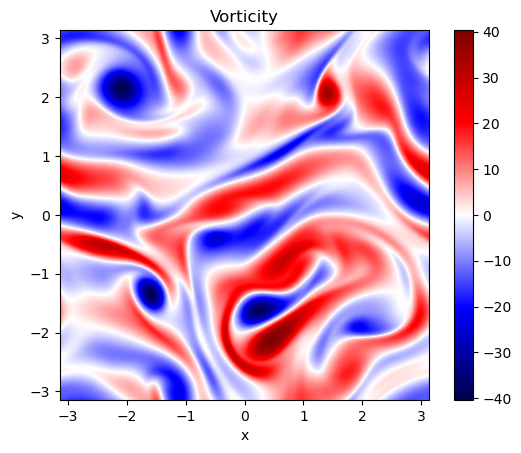

In [4]:
frame = 69

fig, ax = plt.subplots()
limit = max(abs(np.min(dat_vort[:, :, frame])), abs(np.max(dat_vort[:, :, frame])))
img = plt.imshow(dat_vort[:, :, frame], cmap="seismic", origin="lower", extent=[-np.pi, np.pi, -np.pi, np.pi],
                vmin=-limit, vmax=limit)
ax.set_title("Vorticity")
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.colorbar(img)

# Random State Initialization

In [5]:
def set_random(seed):
    np.random.seed(seed=seed)
    random.seed(seed)
    torch.manual_seed(seed)
    
set_random(41)

# Physics-Informed Neural Network

In [6]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True # Find best algo for matrix mult
else:
    device = torch.device('cpu')
    
torch.cuda.empty_cache()

In [7]:
# ResNet for pressure and stream function 
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # parameters
        self.depth = len(layers) - 1
        self.activation = torch.nn.Tanh

        layer_list = list()
        
        for i in range(self.depth - 1):
            layer_list.append(
                ("layer_%d" % i, torch.nn.Linear(layers[i], layers[i + 1]))
            )
            layer_list.append(("activation_%d" % i, self.activation()))

        layer_list.append(
            ("layer_%d" % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )

        layerDict = OrderedDict(layer_list)

        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers[0](x)
        out_in = 0
        for i in range(1, len([x for x in self.layers])):
            if (i % 4) == 1:
                out = self.layers[i](out)
                out_in = out
            elif (i % 4) == 0:
                out = out_in + self.layers[i](out)
            else:
                out = self.layers[i](out)
        return out

In [8]:
# ResNet for forcing 
class DNN2(torch.nn.Module):
    def __init__(self, layers):
        super(DNN2, self).__init__()

        # parameters
        self.depth = len(layers) - 1
        self.activation = torch.nn.Tanh

        layer_list = list()
        
        for i in range(self.depth - 1):
            layer_list.append(
                ("layer_%d" % i, torch.nn.Linear(layers[i], layers[i + 1]))
            )
            layer_list.append(("activation_%d" % i, self.activation()))

        layer_list.append(
            ("layer_%d" % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )

        layerDict = OrderedDict(layer_list)

        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers[0](x)
        out_in = 0
        for i in range(1, len([x for x in self.layers])):
            if (i % 4) == 1:
                out = self.layers[i](out)
                out_in = out
            elif (i % 4) == 0:
                out = out_in + self.layers[i](out)
            else:
                out = self.layers[i](out)
        return out

In [9]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, x, y, t, u, v, x_eqs, y_eqs, t_eqs, layers_dnn, layers_dnn2, device="cpu", amp=False, weight=1, upd_freq=100):
        
        # data
        self.x = torch.tensor(x, requires_grad=True).float().to(device)
        self.y = torch.tensor(y, requires_grad=True).float().to(device)
        self.t = torch.tensor(t, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.v = torch.tensor(v).float().to(device)
        
        self.U_rms = np.sqrt(np.mean(u**2+v**2))
        self.L = np.pi
        self.T = self.L/self.U_rms
        
        # collocation + data points
        self.x_eqs = torch.tensor(x_eqs, requires_grad=True).float().to(device)
        self.y_eqs = torch.tensor(y_eqs, requires_grad=True).float().to(device)
        self.t_eqs = torch.tensor(t_eqs, requires_grad=True).float().to(device)
              
        # settings
        self.upd_freq = upd_freq
        self.weight = weight
        self.device = device
        self.amp = amp
        
        if self.amp and (device == "cpu"):
            raise RuntimeError(
                "AMP is a CUDA feature, but your device appears to be a CPU."
            )
        
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        self.lambda_2 = torch.tensor([-3.0], requires_grad=True).to(device)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        # deep neural networks
        self.dnn = DNN(layers_dnn).to(device)
        self.dnn2 = DNN2(layers_dnn2).to(device)        
        self.dnn2.register_parameter('lambda_1', self.lambda_1)
        self.dnn2.register_parameter('lambda_2', self.lambda_2)        
        self.iter = 0
        
    def net_uvp(self, x, y, t):  
        uvp = self.dnn(torch.cat([x, y, t], dim=1))
        u = uvp[:,0:1]
        v = uvp[:,1:2]
        p = uvp[:,2:3]        
        return u, v, p
    
    def net_force(self, x, y):
        force = self.dnn2(torch.cat([x, y], dim=1))
        fx = force[:,0:1]
        fy = force[:,1:2]
        return fx, fy
    
    def net_NS(self, x, y, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = torch.exp(self.lambda_1)        
        lambda_2 = torch.exp(self.lambda_2)
        u, v, p = self.net_uvp(x, y, t)
        fx, fy = self.net_force(x, y)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
             
        u_y = torch.autograd.grad(
            u, y, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_yy = torch.autograd.grad(
            u_y, y, 
            grad_outputs=torch.ones_like(u_y),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v_t = torch.autograd.grad(
            v, t, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v_x = torch.autograd.grad(
            v, x, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v_y = torch.autograd.grad(
            v, y, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v_xx = torch.autograd.grad(
            v_x, x, 
            grad_outputs=torch.ones_like(v_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v_yy = torch.autograd.grad(
            v_y, y, 
            grad_outputs=torch.ones_like(v_y),
            retain_graph=True,
            create_graph=True
        )[0]
        
        p_x = torch.autograd.grad(
            p, x, 
            grad_outputs=torch.ones_like(p),
            retain_graph=True,
            create_graph=True
        )[0]
        
        p_y = torch.autograd.grad(
            p, y, 
            grad_outputs=torch.ones_like(p),
            retain_graph=True,
            create_graph=True
        )[0]
        
        fx_x = torch.autograd.grad(
            fx, x, 
            grad_outputs=torch.ones_like(fx),
            retain_graph=True,
            create_graph=True
        )[0]
        
        fy_y = torch.autograd.grad(
            fy, y, 
            grad_outputs=torch.ones_like(fy),
            retain_graph=True,
            create_graph=True
        )[0]
              
        f_u = (u_t + (u*u_x + v*u_y) + p_x + lambda_1*u - lambda_2*(u_xx + u_yy) - fx)*self.T/self.U_rms
        f_v = (v_t + (u*v_x + v*v_y) + p_y + lambda_1*v - lambda_2*(v_xx + v_yy) - fy)*self.T/self.U_rms
        f_div = (u_x + v_y)*self.L/self.U_rms
        f2_div = (fx_x + fy_y)*(self.L/self.U_rms)*(self.L/self.U_rms)

        return f_u, f_v, f_div, f2_div
    
    def plot_loss(self, loss, lambdas, optimizer):
        clear_output(wait=True)
        display(self.prbar.container)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        epochs_ = np.arange(0, 100 * (len(loss)), 100)
        
        ax1.plot(epochs_, loss, color="C0")
        ax1.set_yscale("log")
        ax1.set_ylabel("loss")
        ax1.set_xlabel("epoch")

        ax2.plot(
            epochs_,
            np.abs(np.array(lambdas[0]) - 0.1) / 0.1 * 100,
            color="C1",
            label=r"Error $\alpha$",
        )
        ax2.set_ylabel(r"Error $\alpha$, %")
        ax2.set_xlabel("epoch")
        ax2.set_yscale("log")
        
        ax3.plot(
            epochs_,
            np.abs(np.array(lambdas[1]) - 0.01) / 0.01 * 100,
            color="C2",
            label=r"Error $\nu$",
        )
        ax3.set_ylabel(r"Error $\nu$, %")
        ax3.set_xlabel("epoch")
        ax3.set_yscale("log")
        
        fig.suptitle(str(optimizer) + " train graphs")
        plt.tight_layout()
        plt.show()
    
    def loss_func(self):
        u_data, v_data, p_data = self.net_uvp(self.x, self.y, self.t)
        loss_mse = torch.mean((self.u - u_data)**2 + (self.v - v_data)**2)/(self.U_rms**2)
        
        f_u_eqs, f_v_eqs, f_div_eqs, f2_div_eqs = self.net_NS(self.x_eqs, self.y_eqs, self.t_eqs)
        loss_eqs = torch.mean(f_u_eqs**2 + f_v_eqs**2 + f_div_eqs**2 + f2_div_eqs**2)
        
        loss = loss_mse + self.weight*loss_eqs
        
        self.optimizer.zero_grad()
        loss.backward()
        
        if self.iter % self.upd_freq == 0:
            if self.log == "text":
                print(
                    'It-LBFGS: %d, Loss: %e, alpha: %.3f, nu: %.5f' % 
                    (
                        self.iter,
                        loss.item(), 
                        torch.exp(self.lambda_1.detach()).item(), 
                        torch.exp(self.lambda_2.detach()).item()
                    )
                )
            else:
                self.losses_lbfgs.append(loss.detach().cpu().numpy())
                self.lambdas_1_lbfgs.append(
                    torch.exp(self.lambda_1.detach().cpu()).numpy()
                )
                self.lambdas_2_lbfgs.append(
                    torch.exp(self.lambda_2.detach().cpu()).numpy()
                )
                self.plot_loss(
                    loss=self.losses_lbfgs,
                    lambdas=(self.lambdas_1_lbfgs, self.lambdas_2_lbfgs),
                    optimizer="L-BFGS",
                )
                
        self.iter += 1
        self.prbar.update(1)
        return loss
    
    def train_adam(self, nIter, learn_rate=1e-3, log="plot"):
        self.prbar = tqdm(iterable=range(nIter), leave=True)
        self.prbar.set_description("Epoch")
        
        self.dnn.train()
        self.dnn2.train()
        self.optimizer_Adam = torch.optim.Adam(list(self.dnn.parameters())+list(self.dnn2.parameters()), lr=learn_rate)
        
        #scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer_Adam, 
        #                                                 milestones=[30000, 80000], gamma=0.5)
        
        self.losses_Adam = []
        self.lambdas_1_Adam = []
        self.lambdas_2_Adam = []
        
        if self.amp:
            scaler = GradScaler()
        
        for epoch in self.prbar:
            self.epoch = epoch
            
            if self.amp:
                with torch.cuda.amp.autocast(dtype=torch.float16):
                    u_data, v_data, p_data = self.net_uvp(self.x, self.y, self.t)
                    loss_mse = torch.mean((self.u - u_data)**2 + (self.v - v_data)**2)/(self.U_rms**2)
                    
                    f_u_eqs, f_v_eqs, f_div_eqs, f2_div_eqs = self.net_NS(self.x_eqs, self.y_eqs, self.t_eqs)
                    loss_eqs = torch.mean(f_u_eqs**2 + f_v_eqs**2 + f_div_eqs**2 + f2_div_eqs**2)
                    
                    loss = loss_mse + self.weight*loss_eqs
            
                    self.optimizer_Adam.zero_grad(set_to_none=True)
                    scaler.scale(loss).backward()
                    scaler.step(self.optimizer_Adam)
                    scaler.update()
            else:
                u_data, v_data, p_data = self.net_uvp(self.x, self.y, self.t)
                loss_mse = torch.mean((self.u - u_data)**2 + (self.v - v_data)**2)/(self.U_rms**2)
                    
                f_u_eqs, f_v_eqs, f_div_eqs, f2_div_eqs = self.net_NS(self.x_eqs, self.y_eqs, self.t_eqs)
                loss_eqs = torch.mean(f_u_eqs**2 + f_v_eqs**2 + f_div_eqs**2 + f2_div_eqs**2)
                    
                loss = loss_mse + self.weight*loss_eqs
            
                # Backward and optimize
                self.optimizer_Adam.zero_grad(set_to_none=True)
                loss.backward()
                self.optimizer_Adam.step()
                
            #scheduler.step()
            
            if epoch % self.upd_freq == 0:
                if log == "text":                
                    print(
                        'It-adam: %d, Loss: %.5e, alpha: %.3f, nu: %.5f' % 
                        (
                            epoch, 
                            loss.item(), 
                            torch.exp(self.lambda_1).item(), 
                            torch.exp(self.lambda_2).item()
                        )
                    )
                else:
                    self.losses_Adam.append(loss.detach().cpu().numpy())
                    self.lambdas_1_Adam.append(
                        torch.exp(self.lambda_1).detach().cpu().numpy()
                    )
                    self.lambdas_2_Adam.append(
                        torch.exp(self.lambda_2).detach().cpu().numpy()
                    )
                    self.plot_loss(
                        loss=self.losses_Adam,
                        lambdas=(self.lambdas_1_Adam, self.lambdas_2_Adam),
                        optimizer="Adam",
                    )
                    
                

    def train_lbfgs(self, log="plot", max_iter=100000):
        self.prbar = tqdm(iterable=range(max_iter), leave=True)
        self.prbar.set_description("Epoch")
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            list(self.dnn.parameters())+list(self.dnn2.parameters()), 
            lr=1.0, 
            max_iter=max_iter, 
            history_size=100,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        self.dnn.train()
        self.dnn2.train()
        
        self.losses_lbfgs = []
        self.lambdas_1_lbfgs = []
        self.lambdas_2_lbfgs = []

        self.log = log
                        
        # Backward and optimize
        self.optimizer.step(self.loss_func)
    
    def predict(self, x_star, y_star, t_star):
        
        x = torch.tensor(x_star, requires_grad=True).float().to(device)
        y = torch.tensor(y_star, requires_grad=True).float().to(device)
        t = torch.tensor(t_star, requires_grad=True).float().to(device)
        
        self.dnn.eval()
        self.dnn2.eval()
        
        u, v, p = self.net_uvp(x, y, t)
        fx, fy = self.net_force(x, y)
        f_u, f_v, f_div, f2_div = self.net_NS(x, y, t)
        
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        p = p.detach().cpu().numpy()
        fx = fx.detach().cpu().numpy()
        fy = fy.detach().cpu().numpy()
        f_u = f_u.detach().cpu().numpy()
        f_v = f_v.detach().cpu().numpy()
        f_div = f_div.detach().cpu().numpy()
        f2_div = f2_div.detach().cpu().numpy()
        
        return u, v, p, fx, fy, f_u, f_v, f_div, f2_div

# Training Data

In [10]:
# possible values of coordinates and time
Nx = 256
Ny = 256
T = 200

grid_x = np.linspace(-np.pi, 0, Nx, endpoint=False)
grid_y = np.linspace(-np.pi, 0, Ny, endpoint=False)
grid_t = np.linspace(0, 4, T, endpoint=False)

N_train = 30000
N_col = 60000

# random sampling
idx = [randint(0, Nx-1) for p in range(N_train)]
idy = [randint(0, Ny-1) for p in range(N_train)]
idt = [randint(0, T-1) for p in range(N_train)]

idx2 = [randint(0, Nx-1) for p in range(N_col)]
idy2 = [randint(0, Ny-1) for p in range(N_col)]
idt2 = [randint(0, T-1) for p in range(N_col)]

# training dataset
x_train = grid_x[idx][:, None]
y_train = grid_y[idy][:, None]
t_train = grid_t[idt][:, None]
u_train = dat_velx[idy, idx, np.array(idt)][:, None]
v_train = dat_vely[idy, idx, np.array(idt)][:, None]

# collocations points
x_col = grid_x[idx2][:, None]
y_col = grid_y[idy2][:, None]
t_col = grid_t[idt2][:, None]

# eqs points = train + col points
x_eqs = np.vstack((x_train, x_col))
y_eqs = np.vstack((y_train, y_col))
t_eqs = np.vstack((t_train, t_col))

### Application of noise

In [11]:
eps = 0.05

factor_u = 1 + eps*np.random.randn(N_train,1)
factor_v = 1 + eps*np.random.randn(N_train,1)

u_train_noise = u_train*factor_u
v_train_noise = v_train*factor_v

# Training

In [12]:
layers_dnn = [3, 250, 250, 250, 250, 250, 250, 250, 3]
layers_dnn2 = [2, 30, 30, 30, 30, 30, 2]

model = PhysicsInformedNN(x_train, y_train, t_train,
                          u_train_noise, v_train_noise, x_eqs, y_eqs, t_eqs,
                          layers_dnn, layers_dnn2, device=device, amp=True, weight=0.02)

Epoch: 100%|#########9| 100000/100001 [3:58:19<00:00,  7.27it/s]

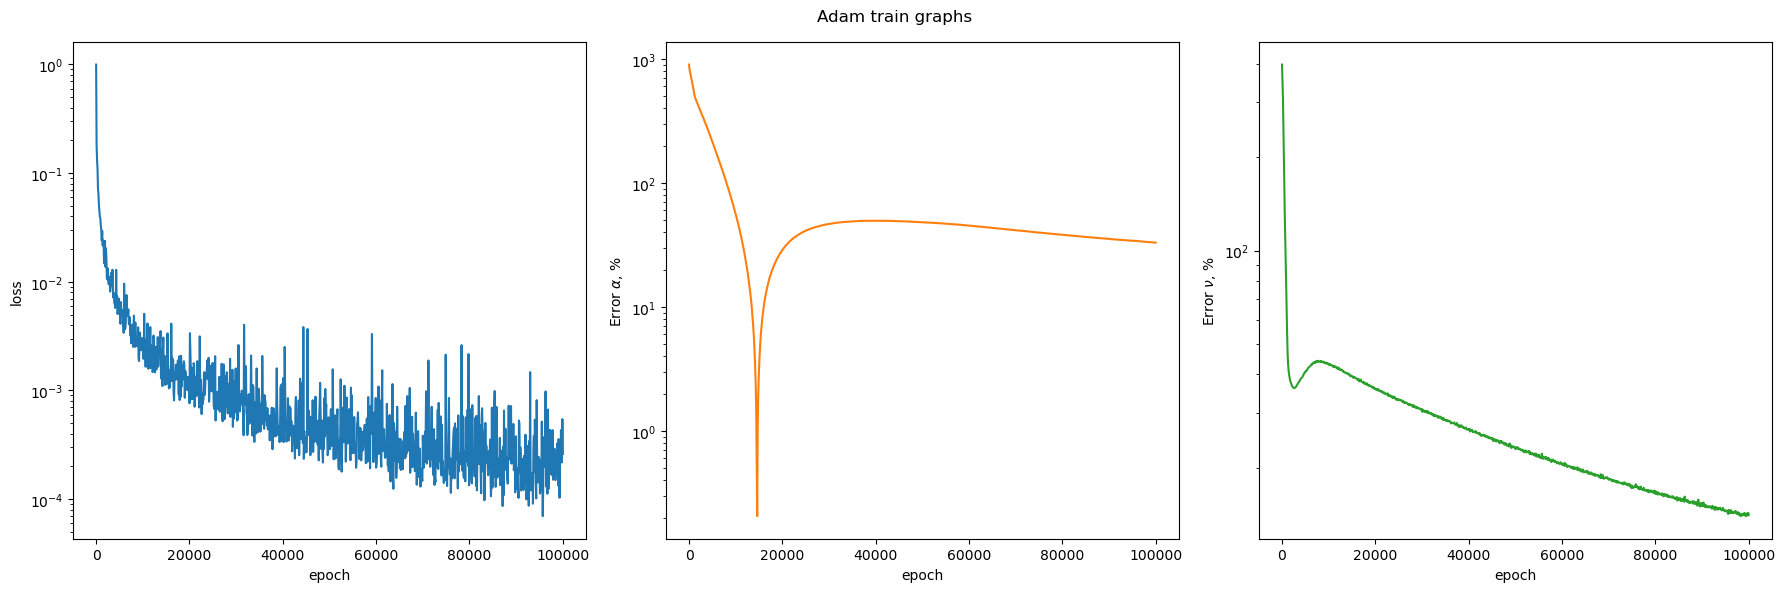

In [12]:
model.train_adam(100001, 1e-3, log='plot')

Epoch:   1%|          | 9500/1000000 [1:03:24<108:58:50,  2.52it/s]

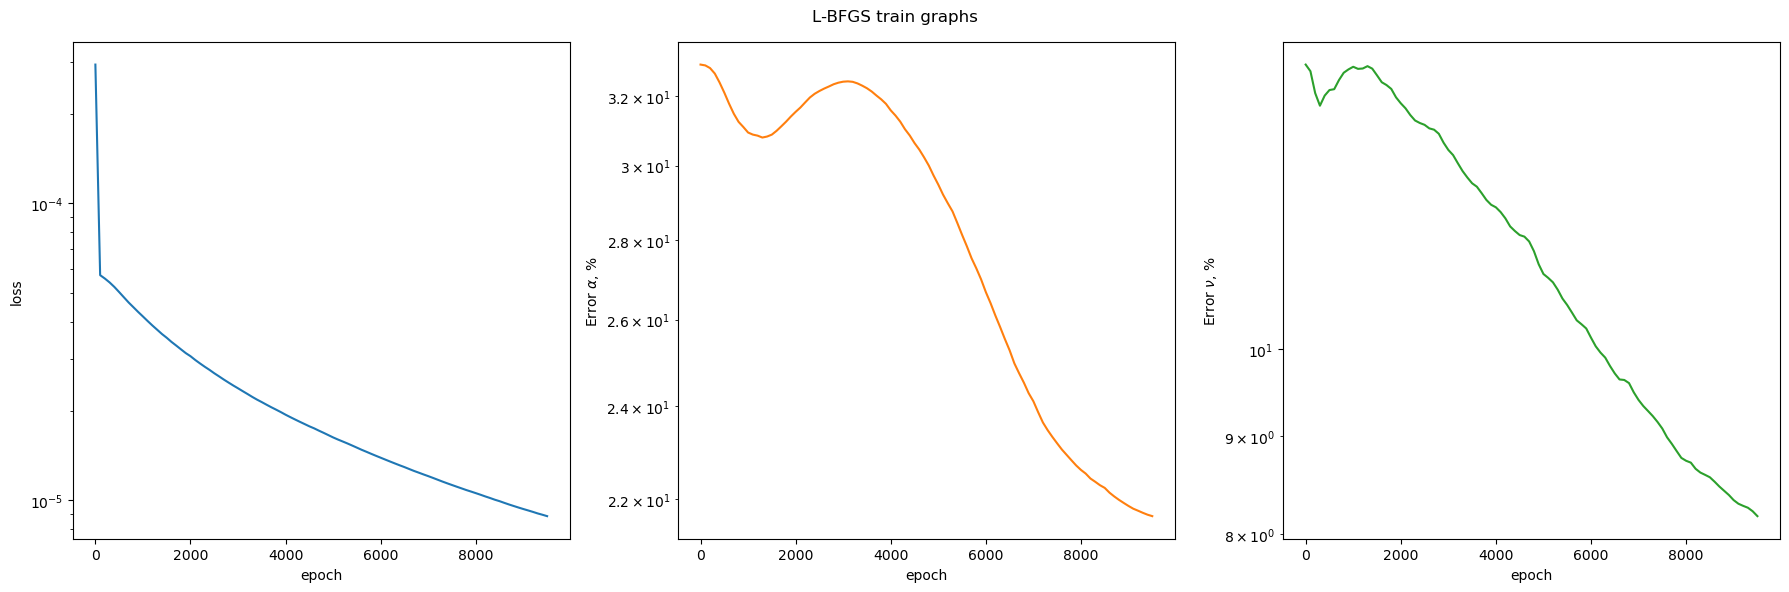

In [ ]:
model.train_lbfgs(log='plot', max_iter=1000000)

#### Save Model

In [ ]:
torch.save(model.dnn.state_dict(), './saved_models/Ndata_3000/A01_dnn_3000_s41.pth')
torch.save(model.dnn2.state_dict(), './saved_models/Ndata_3000/A01_dnn2_3000_s41.pth')
torch.save([model.lambda_1, model.lambda_2], './saved_models/Ndata_3000/A01_params_3000_s41.pt')

#### Load Model

In [13]:
model.dnn.load_state_dict(torch.load('./noise_0/A01_dnn_250_7_30_5_30+60k_s41.pth'))
model.dnn2.load_state_dict(torch.load('./noise_0/A01_dnn2_250_7_30_5_30+60k_s41.pth'))
[model.lambda1, model.lambda2] = torch.load('./noise_0/A01_params_250_7_30_5_30+60k_s41.pt')

# Prediction & Testing

In [14]:
error_velocity = np.zeros(T)
error_pressure = np.zeros(T)

P_exact = np.zeros((Ny, Nx, T))
P_pred = np.zeros((Ny, Nx, T))

time_step = 0.02

X, Y = np.meshgrid(grid_x,grid_y)

x_star = X.flatten()[:, None]
y_star = Y.flatten()[:, None]
X_star = np.hstack((x_star,y_star))

for i in range(T):
    time = i*time_step
    frame = i    
    
    t_star = x_star*0+time
    
    u_star = dat_velx[0:Ny, 0:Nx, frame]
    v_star = dat_vely[0:Ny, 0:Nx, frame]
    p_star = dat_p[0:Ny, 0:Nx, frame]

    UU_exact = griddata(X_star, u_star.flatten(), (X, Y), method='nearest')
    VV_exact = griddata(X_star, v_star.flatten(), (X, Y), method='nearest')
    PP_exact = griddata(X_star, p_star.flatten(), (X, Y), method='nearest')

    P_exact[:,:,i] = PP_exact

    Px_exact = np.gradient(PP_exact, np.pi/Nx, axis=1)
    Py_exact = np.gradient(PP_exact, np.pi/Ny, axis=0)
    Pxx_exact = np.gradient(Px_exact, np.pi/Nx, axis=1)
    Pyy_exact = np.gradient(Py_exact, np.pi/Ny, axis=0)
    P_laplace_exact = Pxx_exact + Pyy_exact
    
    # prediction
    u_pred, v_pred, p_pred, fx_pred, fy_pred, \
            fu_pred, fv_pred, fdiv_pred, f2div_pred = model.predict(x_star, y_star, t_star)

    UU_pred = griddata(X_star, u_pred.flatten(), (X, Y), method='nearest')
    VV_pred = griddata(X_star, v_pred.flatten(), (X, Y), method='nearest')
    PP_pred = griddata(X_star, p_pred.flatten(), (X, Y), method='nearest')

    P_pred[:,:,i] = PP_pred

    Px_pred = np.gradient(PP_pred, np.pi/Nx, axis=1)
    Py_pred = np.gradient(PP_pred, np.pi/Ny, axis=0)
    Pxx_pred = np.gradient(Px_pred, np.pi/Nx, axis=1)
    Pyy_pred = np.gradient(Py_pred, np.pi/Ny, axis=0)
    P_laplace_pred = Pxx_pred + Pyy_pred    
    
    error_velocity[i] = np.sqrt(np.mean((UU_pred-UU_exact)**2 + (VV_pred-VV_exact)**2)/np.mean(UU_exact**2 + VV_exact**2))
    error_pressure[i] = np.sqrt(np.mean((P_laplace_pred-P_laplace_exact)**2)/np.mean(P_laplace_exact**2))

lambda_1_value = model.lambda_1.detach().cpu().numpy()
lambda_2_value = model.lambda_2.detach().cpu().numpy()
lambda_1_value = np.exp(lambda_1_value)
lambda_2_value = np.exp(lambda_2_value)
error_lambda_1 = np.abs(lambda_1_value - 0.1)/0.1 * 100
error_lambda_2 = np.abs(lambda_2_value - 0.01)/0.01 * 100

print('Error velocity: %.5f%%' % (np.mean(error_velocity)*100))    
print('Error laplace pressure: %.5f%%' % (np.mean(error_pressure)*100))  
print('Error alpha: %.5f%%' % (error_lambda_1))                             
print('Error nu: %.5f%%' % (error_lambda_2)) 

Error velocity: 0.21065%
Error laplace pressure: 3.79818%
Error alpha: 4.26915%
Error nu: 1.56489%


### Modified pressure

In [15]:
P_exact_mod = np.zeros((Ny, Nx, T))
P_pred_mod = np.zeros((Ny, Nx, T))

P_exact_mean = np.mean(P_exact, axis=2)
P_pred_mean = np.mean(P_pred, axis=2)

for i in range(T):
    P_exact_mod[:,:,i] = P_exact[:,:,i] - P_exact_mean
    P_pred_mod[:,:,i] = P_pred[:,:,i] - P_pred_mean

error_pressure_mod = np.zeros(T)

for i in range(T):
    p_star = P_exact_mod[:,:,i]
    p_pred = P_pred_mod[:,:,i]
    error_pressure_mod[i] = np.linalg.norm(p_star.flatten()-np.mean(p_star.flatten())-p_pred.flatten()+np.mean(p_pred.flatten()),2)/np.linalg.norm(p_star.flatten()-np.mean(p_star.flatten()),2)
    
print('Error modified pressure: %.5f%%' % (np.mean(error_pressure_mod)*100)) 

Error modified pressure: 0.56295%


Text(0.5, 1.0, 'PINN')

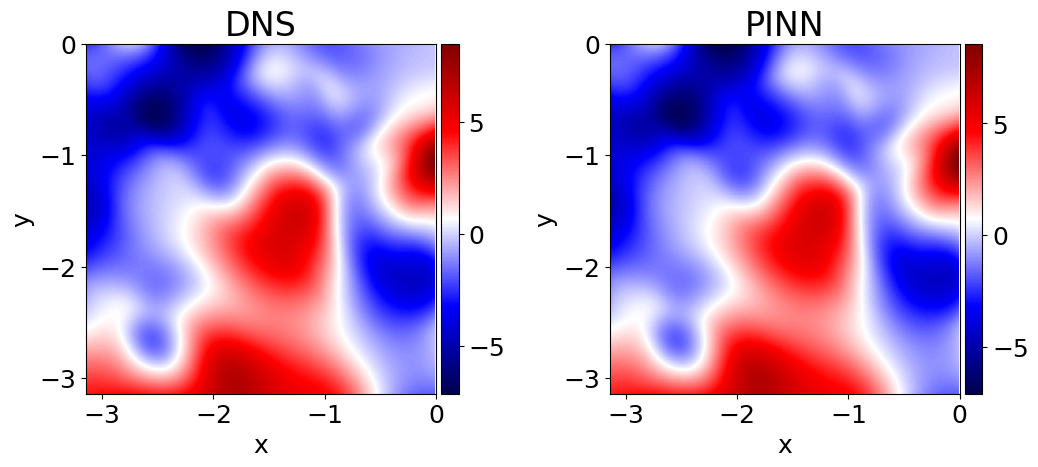

In [16]:
time = np.array([3.0]) # from 0 to 3.98 with step 0.02
frame=(np.rint(time/0.02)).astype(int)

p_exact = P_exact_mod[:,:,frame]
p_pred = P_pred_mod[:,:,frame]

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
ax.remove()

plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels

########     Exact Pressure     ########### 
gs2 = gridspec.GridSpec(1, 2)
gs2.update(top=1, bottom=1-1/2, left=0.1, right=0.9, hspace=0.2)
ax = plt.subplot(gs2[:, 0])

h = ax.imshow(p_exact-np.mean(p_exact), cmap='seismic', #vmin=-limit, vmax=limit,
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax, ticks=[-5, 0, 5])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks(np.arange(-3, 0.1, step=1))
ax.set_yticks(np.arange(-3, 0.1, step=1))
ax.set_aspect('equal', 'box')
ax.set_title('DNS', fontsize = 24)

########     Predicted Pressure     ########### 
ax = plt.subplot(gs2[:, 1])
h = ax.imshow(p_pred-np.mean(p_pred), cmap='seismic', #vmin=-limit, vmax=limit,
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax, ticks=[-5, 0, 5])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks(np.arange(-3, 0.1, step=1))
ax.set_yticks(np.arange(-3, 0.1, step=1))
ax.set_aspect('equal', 'box')
ax.set_title('PINN', fontsize = 24)


#plt.savefig('./P_mod.svg', format="svg", bbox_inches='tight')

# Error Visualization

In [17]:
# test data
time = np.array([3.0]) # от 0 до 3.98 c шагом 0.02
frame=(np.rint(time/0.02)).astype(int)

X, Y = np.meshgrid(grid_x,grid_y)

x_star = X.flatten()[:, None]
y_star = Y.flatten()[:, None]
t_star = x_star*0+time

X_star = np.hstack((x_star,y_star))

u_star = dat_velx[0:Ny, 0:Nx, frame]
v_star = dat_vely[0:Ny, 0:Nx, frame]
p_star = dat_p[0:Ny, 0:Nx, frame]

UU_exact = griddata(X_star, u_star.flatten(), (X, Y), method='nearest')
VV_exact = griddata(X_star, v_star.flatten(), (X, Y), method='nearest')
PP_exact = griddata(X_star, p_star.flatten(), (X, Y), method='nearest')

Px_exact = np.gradient(PP_exact, np.pi/Nx, axis=1)
Py_exact = np.gradient(PP_exact, np.pi/Ny, axis=0)
Pxx_exact = np.gradient(Px_exact, np.pi/Nx, axis=1)
Pyy_exact = np.gradient(Py_exact, np.pi/Ny, axis=0)
P_laplace_exact = Pxx_exact + Pyy_exact

# prediction
u_pred, v_pred, p_pred, fx_pred, fy_pred, \
            fu_pred, fv_pred, fdiv_pred, f2div_pred = model.predict(x_star, y_star, t_star)

UU_pred = griddata(X_star, u_pred.flatten(), (X, Y), method='nearest')
VV_pred = griddata(X_star, v_pred.flatten(), (X, Y), method='nearest')
PP_pred = griddata(X_star, p_pred.flatten(), (X, Y), method='nearest')
FFX_pred = griddata(X_star, fx_pred.flatten(), (X, Y), method='nearest')
FFY_pred = griddata(X_star, fy_pred.flatten(), (X, Y), method='nearest')

Px_pred = np.gradient(PP_pred, np.pi/Nx, axis=1)
Py_pred = np.gradient(PP_pred, np.pi/Ny, axis=0)
Pxx_pred = np.gradient(Px_pred, np.pi/Nx, axis=1)
Pyy_pred = np.gradient(Py_pred, np.pi/Ny, axis=0)
P_laplace_pred = Pxx_pred + Pyy_pred   

error_vel = np.sqrt(np.mean((UU_pred-UU_exact)**2 + (VV_pred-VV_exact)**2)/np.mean(UU_exact**2 + VV_exact**2))
error_p = np.sqrt(np.mean((P_laplace_pred-P_laplace_exact)**2)/np.mean(P_laplace_exact**2))
#error_p = np.linalg.norm(p_star.flatten()-np.mean(p_star.flatten())-p_pred.flatten()+np.mean(p_pred.flatten()),2)/np.linalg.norm(p_star.flatten()-np.mean(p_star.flatten()),2)

print('Error vel: %.5f%%' % (error_vel*100))    
print('Error laplace p: %.5f%%' % (error_p*100))  

Error vel: 0.20915%
Error laplace p: 4.82383%


### Analysis of the force

In [18]:
def force_x(x, y):
    return 10*np.sin(5*y)

def force_y(x, y):
    return 0*x+0*y

def force_curl(x, y):
    return -50*np.cos(5*y)

FFX_exact = force_x(X, Y)
FFY_exact = force_y(X, Y)
#CURL_exact = force_curl(X,Y)

CURL_pred = np.gradient(FFY_pred, np.pi/Nx, axis=1) - np.gradient(FFX_pred, np.pi/Ny, axis=0)
CURL_exact = np.gradient(FFY_exact, np.pi/Nx, axis=1) - np.gradient(FFX_exact, np.pi/Ny, axis=0)

error_curl = np.sqrt(np.mean((CURL_pred-CURL_exact)**2)/np.mean(CURL_exact**2))
print('Error CURL: %.5f%%' % (error_curl*100))

Error CURL: 1.25299%


# Error Plots

Text(0.5, 1.0, 'Difference Vel-X')

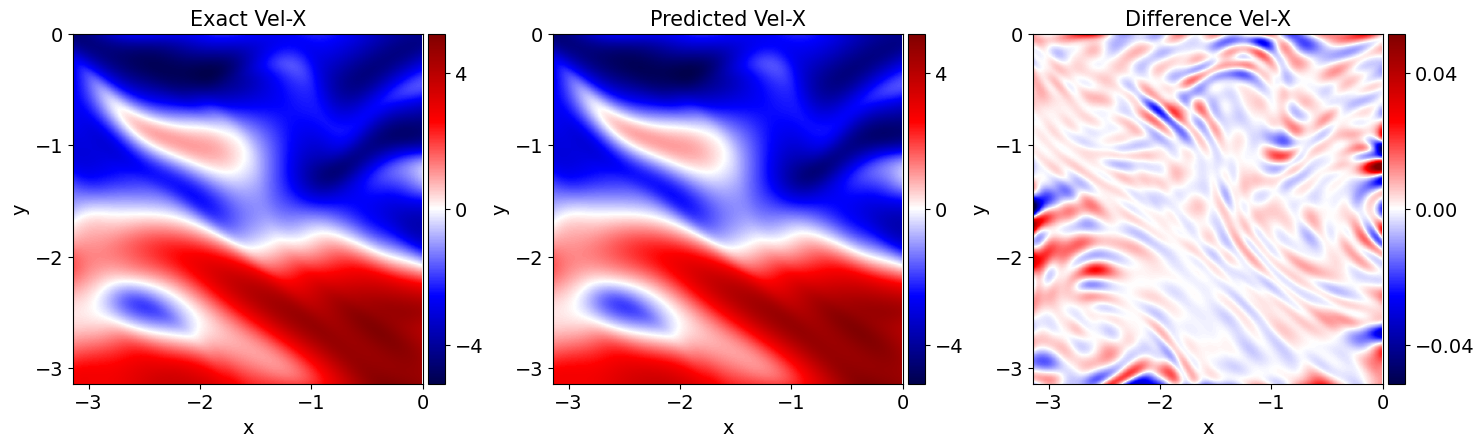

In [19]:
fig = plt.figure(figsize=(17, 7))
ax = fig.add_subplot(111)
ax.remove()

plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels

########     Exact Vel-X     ########### 
gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=1, bottom=1-1/2, left=0.1, right=0.9, wspace=0.2)
ax = plt.subplot(gs2[:, 0])
limit = max(abs(np.min(UU_exact)), abs(np.max(UU_exact)))
h = ax.imshow(UU_exact, cmap='seismic', vmin=-limit, vmax=limit,
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax, ticks=[-4, 0, 4])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks(np.arange(-3, 0.1, step=1))
ax.set_yticks(np.arange(-3, 0.1, step=1))
ax.set_aspect('equal', 'box')
ax.set_title('Exact Vel-X', fontsize = 15)

########     Predicted Vel-X     ########### 
ax = plt.subplot(gs2[:, 1])
h = ax.imshow(UU_pred, cmap='seismic', vmin=-limit, vmax=limit,
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax, ticks=[-4, 0, 4])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks(np.arange(-3, 0.1, step=1))
ax.set_yticks(np.arange(-3, 0.1, step=1))
ax.set_aspect('equal', 'box')
ax.set_title('Predicted Vel-X', fontsize = 15)

########     Difference Vel-X     ########### 
ax = plt.subplot(gs2[:, 2])
h = ax.imshow(UU_exact - UU_pred, cmap='seismic', vmin=-limit/100, vmax=limit/100,
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax, ticks=[-0.04, 0, 0.04])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks(np.arange(-3, 0.1, step=1))
ax.set_yticks(np.arange(-3, 0.1, step=1))
ax.set_aspect('equal', 'box')
ax.set_title('Difference Vel-X', fontsize = 15)

#plt.savefig('./Vx.svg', format="svg", bbox_inches='tight')

Text(0.5, 1.0, 'Difference Vel-Y')

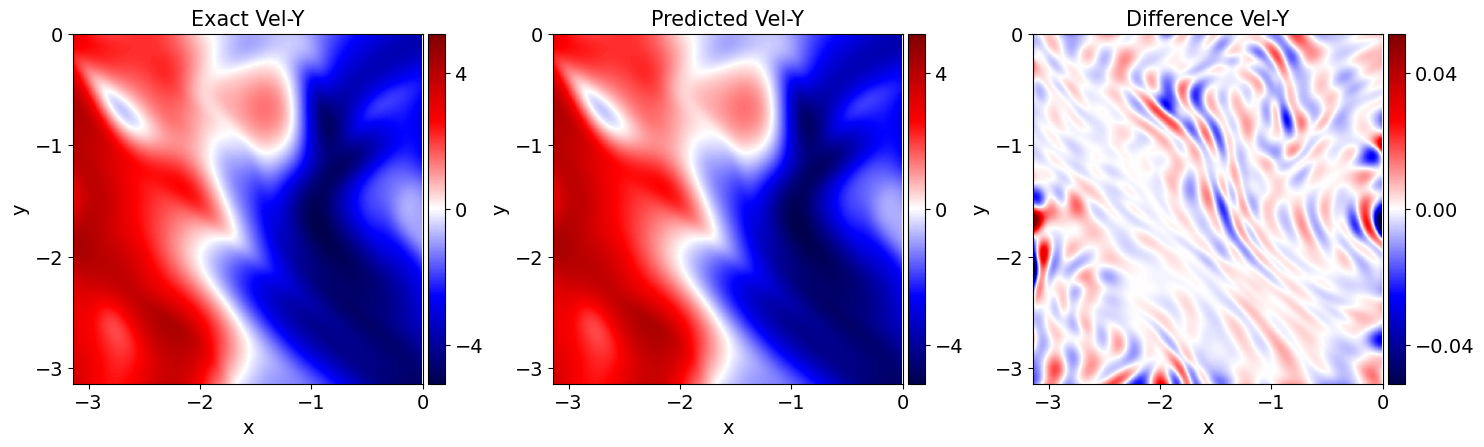

In [20]:
fig = plt.figure(figsize=(17, 7))
ax = fig.add_subplot(111)
ax.remove()

########     Exact Vel-Y     ########### 
gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=1, bottom=1-1/2, left=0.1, right=0.9, wspace=0.2)
ax = plt.subplot(gs2[:, 0])
limit = max(abs(np.min(VV_exact)), abs(np.max(VV_exact)))
h = ax.imshow(VV_exact, cmap='seismic', vmin=-limit, vmax=limit,
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax, ticks=[-4, 0, 4])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks(np.arange(-3, 0.1, step=1))
ax.set_yticks(np.arange(-3, 0.1, step=1))
ax.set_aspect('equal', 'box')
ax.set_title('Exact Vel-Y', fontsize = 15)

########     Predicted Vel-Y     ########### 
ax = plt.subplot(gs2[:, 1])
h = ax.imshow(VV_pred, cmap='seismic', vmin=-limit, vmax=limit,
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax, ticks=[-4, 0, 4])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks(np.arange(-3, 0.1, step=1))
ax.set_yticks(np.arange(-3, 0.1, step=1))
ax.set_aspect('equal', 'box')
ax.set_title('Predicted Vel-Y', fontsize = 15)

########     Difference Vel-Y     ########### 
ax = plt.subplot(gs2[:, 2])
h = ax.imshow(VV_exact - VV_pred, cmap='seismic', vmin=-limit/100, vmax=limit/100,
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax, ticks=[-0.04, 0, 0.04])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks(np.arange(-3, 0.1, step=1))
ax.set_yticks(np.arange(-3, 0.1, step=1))
ax.set_aspect('equal', 'box')
ax.set_title('Difference Vel-Y', fontsize = 15)

#plt.savefig('./Vy.svg', format="svg", bbox_inches='tight')

Text(0.5, 1.0, 'Difference Pressure Laplacian')

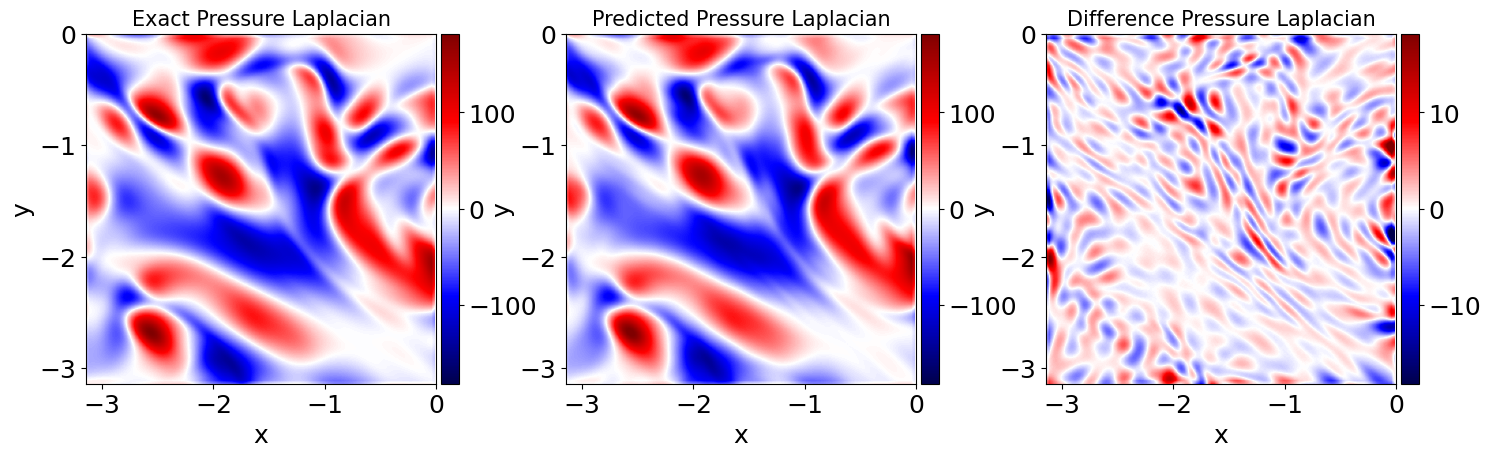

In [26]:
fig = plt.figure(figsize=(17, 7))
ax = fig.add_subplot(111)
ax.remove()

########     Exact Laplace Pressure     ########### 
gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=1, bottom=1-1/2, left=0.1, right=0.9, hspace=0.2)
ax = plt.subplot(gs2[:, 0])
limit = max(abs(np.min(P_laplace_exact)), abs(np.max(P_laplace_exact)))
h = ax.imshow(P_laplace_exact, cmap='seismic', vmin=-limit, vmax=limit,
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks(np.arange(-3, 0.1, step=1))
ax.set_yticks(np.arange(-3, 0.1, step=1))
ax.set_aspect('equal', 'box')
ax.set_title('Exact Pressure Laplacian', fontsize = 15)

########     Predicted Laplace Pressure     ########### 
ax = plt.subplot(gs2[:, 1])
h = ax.imshow(P_laplace_pred, cmap='seismic', vmin=-limit, vmax=limit,
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks(np.arange(-3, 0.1, step=1))
ax.set_yticks(np.arange(-3, 0.1, step=1))
ax.set_aspect('equal', 'box')
ax.set_title('Predicted Pressure Laplacian', fontsize = 15)

########     Difference      ########### 
ax = plt.subplot(gs2[:, 2])
h = ax.imshow(P_laplace_exact-P_laplace_pred, cmap='seismic', vmin=-limit/10, vmax=limit/10,
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks(np.arange(-3, 0.1, step=1))
ax.set_yticks(np.arange(-3, 0.1, step=1))
ax.set_aspect('equal', 'box')
ax.set_title('Difference Pressure Laplacian', fontsize = 15)

#plt.savefig('./P_laplace.svg', format="svg", bbox_inches='tight')

Text(0.5, 1.0, 'Difference Force Curl')

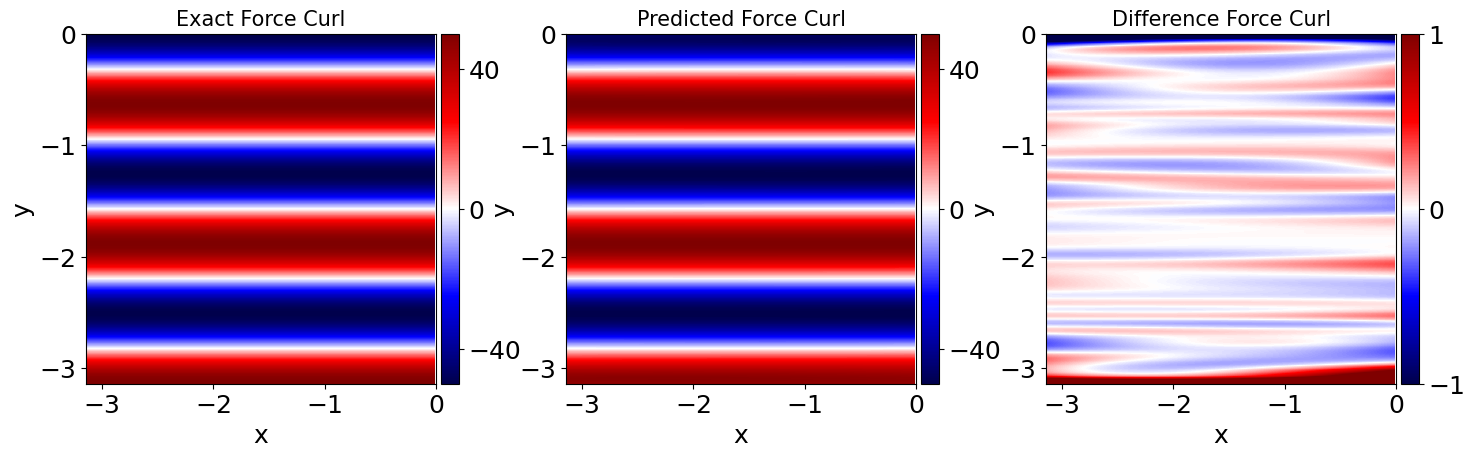

In [29]:
fig = plt.figure(figsize=(17, 7))
ax = fig.add_subplot(111)
ax.remove()

########     Exact Force Curl     ########### 
gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=1, bottom=1-1/2, left=0.1, right=0.9, wspace=0.2)
ax = plt.subplot(gs2[:, 0])
limit = max(abs(np.min(CURL_exact)), abs(np.max(CURL_exact)))
h = ax.imshow(CURL_exact, cmap='seismic', vmin=-limit, vmax=limit,
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax, ticks=[-40,0,40])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks(np.arange(-3, 0.1, step=1))
ax.set_yticks(np.arange(-3, 0.1, step=1))
ax.set_aspect('equal', 'box')
ax.set_title('Exact Force Curl', fontsize = 15)

########     Predicted CURL     ########### 
ax = plt.subplot(gs2[:, 1])
h = ax.imshow(CURL_pred, cmap='seismic', vmin=-limit, vmax=limit,
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax, ticks=[-40,0,40])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks(np.arange(-3, 0.1, step=1))
ax.set_yticks(np.arange(-3, 0.1, step=1))
ax.set_aspect('equal', 'box')
ax.set_title('Predicted Force Curl', fontsize = 15)

########     Difference CURL     ########### 
ax = plt.subplot(gs2[:, 2])
h = ax.imshow(CURL_exact - CURL_pred, cmap='seismic', vmin=-1, vmax=1,
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax, ticks=[-1,0,1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks(np.arange(-3, 0.1, step=1))
ax.set_yticks(np.arange(-3, 0.1, step=1))
ax.set_aspect('equal', 'box')
ax.set_title('Difference Force Curl', fontsize = 15)

#plt.savefig('./force_curl.svg', format="svg", bbox_inches='tight')

In [12]:
model = PhysicsInformedNN(x_train, y_train, t_train, u_train_noise, v_train_noise, x_eqs, y_eqs, t_eqs,
                          layers_dnn, layers_dnn2, device=device, amp=True, weight=0.02)

model2 = PhysicsInformedNN(x_train, y_train, t_train, u_train_noise, v_train_noise, x_eqs, y_eqs, t_eqs,
                          layers_dnn, layers_dnn2, device=device, amp=True, weight=0.02)

model.dnn.load_state_dict(torch.load('./saved_models/noise_1/A01_dnn_250_7_30_5_30+60k_s44_n1.pth', map_location=device))
model.dnn2.load_state_dict(torch.load('./saved_models/noise_1/A01_dnn2_250_7_30_5_30+60k_s44_n1.pth', map_location=device))
[model.lambda1, model.lambda2] = torch.load('./saved_models/noise_1/A01_params_250_7_30_5_30+60k_s44_n1.pt', map_location=device)

model2.dnn.load_state_dict(torch.load('./saved_models/noise_5/A01_dnn_250_7_30_5_30+60k_s42_n5.pth', map_location=device))
model2.dnn2.load_state_dict(torch.load('./saved_models/noise_5/A01_dnn2_250_7_30_5_30+60k_s42_n5.pth', map_location=device))
[model2.lambda1, model2.lambda2] = torch.load('./saved_models/noise_5/A01_params_250_7_30_5_30+60k_s42_n5.pt', map_location=device)

In [13]:
vel_DNS = np.zeros((Nx*Ny, T))
p_DNS = np.zeros((Nx*Ny, T))
f_DNS = np.zeros(Nx*Ny)

vel_NN = np.zeros((Nx*Ny, T))
vel_NN2 = np.zeros((Nx*Ny, T))
p_NN = np.zeros((Nx*Ny, T))
p_NN2 = np.zeros((Nx*Ny, T))
f_NN = np.zeros(Nx*Ny)
f_NN2 = np.zeros(Nx*Ny)

time_step = 0.02

X, Y = np.meshgrid(grid_x,grid_y)
x_star = X.flatten()[:, None]
y_star = Y.flatten()[:, None]

def force_x(x, y):
    return 10*np.sin(5*y)

def force_y(x, y):
    return 0*x+0*y

FFX_exact = force_x(X, Y)
FFY_exact = force_y(X, Y)

for i in range(T):
    time = i*time_step
    frame = i    
    
    t_star = x_star*0+time   
    
    # prediction
    u_pred, v_pred, p_pred = model.predict(x_star, y_star, t_star)[0:3]
    u_pred2, v_pred2, p_pred2 = model2.predict(x_star, y_star, t_star)[0:3]

    vel_DNS[:,frame] = np.sqrt((dat_velx[0:Ny, 0:Nx, frame].flatten())**2+(dat_vely[0:Ny, 0:Nx, frame].flatten())**2)
    vel_NN[:,frame] = np.sqrt((u_pred.flatten())**2+(v_pred.flatten())**2)
    vel_NN2[:,frame] = np.sqrt((u_pred2.flatten())**2+(v_pred2.flatten())**2)

    p_DNS[:,frame] = dat_p[0:Ny, 0:Nx, frame].flatten() - np.mean(dat_p[0:Ny, 0:Nx, frame].flatten())
    p_NN[:,frame] = p_pred.flatten() - np.mean(p_pred.flatten())
    p_NN2[:,frame] = p_pred2.flatten() - np.mean(p_pred2.flatten())

fx_pred, fy_pred = model.predict(x_star, y_star, t_star)[3:5]
fx_pred2, fy_pred2 = model2.predict(x_star, y_star, t_star)[3:5]

f_DNS = np.sqrt((force_x(x_star, y_star).flatten())**2 + (force_y(x_star, y_star).flatten())**2)
f_NN = np.sqrt((fx_pred.flatten()**2) + (fy_pred.flatten()**2))
f_NN2 = np.sqrt((fx_pred2.flatten()**2) + (fy_pred2.flatten()**2))

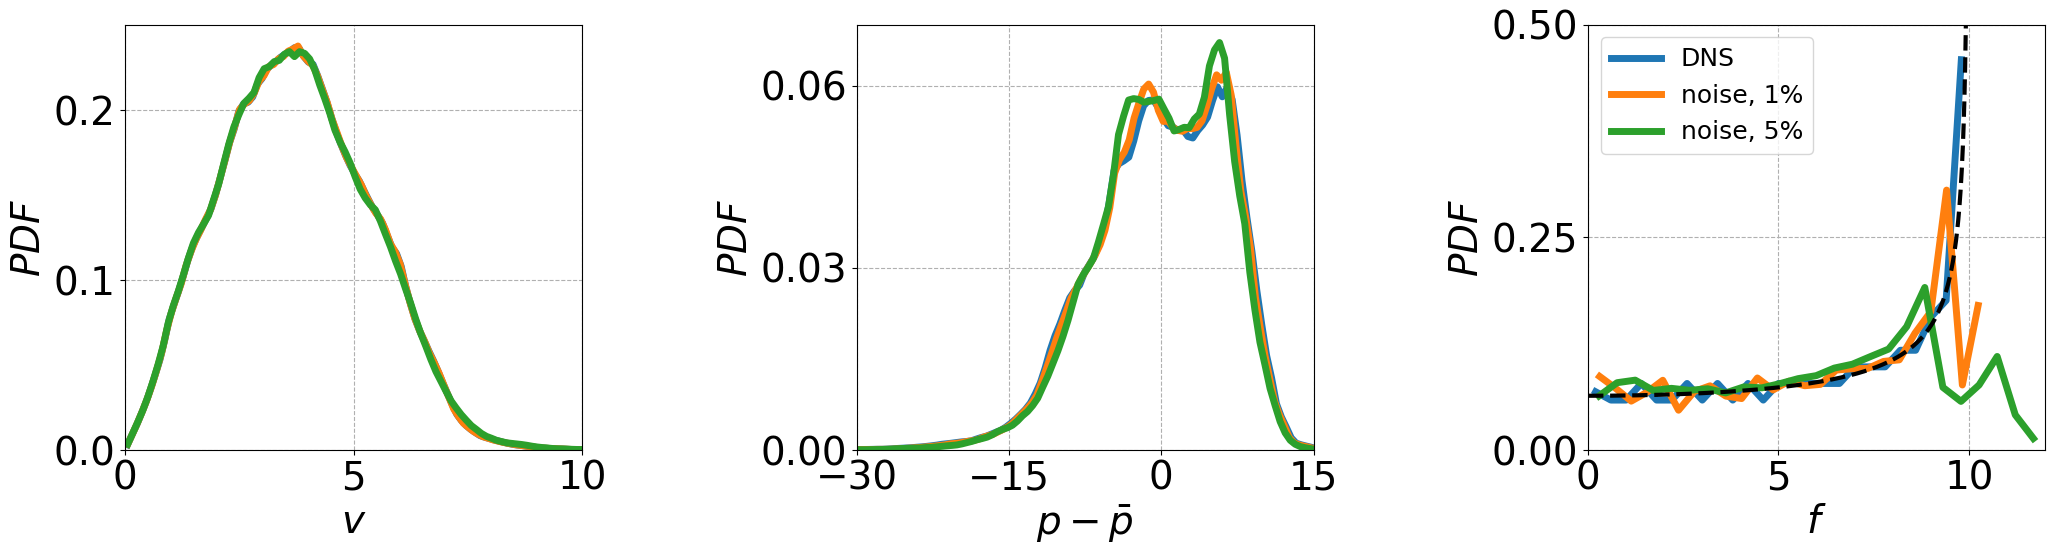

In [25]:
def rho_force(x):
    return (1-x**2/100)**(-0.5)/(5*np.pi)

fig = plt.figure(figsize=(24, 8.5))
ax = fig.add_subplot(111)
ax.remove()

plt.rc('axes', labelsize=28)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=28)    # fontsize of the tick labels
plt.rc('ytick', labelsize=28)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # fontsize of the tick labels

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans',
                               'Lucida Grande', 'Verdana']

gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=1, bottom=1-1/2, left=0.1, right=0.9, wspace=0.6)
ax = plt.subplot(gs2[:, 0])

########################## Velocity ##############################

hist, bins = np.histogram(vel_DNS.flatten(), bins=100, density=True)
bin_centers = (bins[1:]+bins[:-1])*0.5
ax.plot(bin_centers, hist, linestyle='-', linewidth=5, label='DNS')

hist, bins = np.histogram(vel_NN.flatten(), bins=100, density=True)
bin_centers = (bins[1:]+bins[:-1])*0.5
ax.plot(bin_centers, hist, linestyle='-', linewidth=5, label=r'noise, 1%')

hist, bins = np.histogram(vel_NN2.flatten(), bins=100, density=True)
bin_centers = (bins[1:]+bins[:-1])*0.5
ax.plot(bin_centers, hist, linestyle='-', linewidth=5, label=r'noise, 5%')

ax.set_xlabel(r'$v$')  # Add an x-label to the axes.
ax.set_ylabel(r'$PDF$')  # Add a y-label to the axes.

ax.grid(True, linestyle='--')
#ax.set_yscale('log')

ax.set_xlim(0, 10)
ax.set_ylim(0, 0.25)
#ax.legend()

ax.set_yticks(np.arange(0, 0.25, step=0.1))
ax.set_xticks(np.arange(0, 11, step=5))

########################### Pressure ########################

ax = plt.subplot(gs2[:, 1])

hist, bins = np.histogram(p_DNS.flatten(), bins=100, density=True)
bin_centers = (bins[1:]+bins[:-1])*0.5
ax.plot(bin_centers, hist, linestyle='-', linewidth=5, label='DNS')

hist, bins = np.histogram(p_NN.flatten(), bins=100, density=True)
bin_centers = (bins[1:]+bins[:-1])*0.5
ax.plot(bin_centers, hist, linestyle='-', linewidth=5, label=r'noise, 1%')

hist, bins = np.histogram(p_NN2.flatten(), bins=100, density=True)
bin_centers = (bins[1:]+bins[:-1])*0.5
ax.plot(bin_centers, hist, linestyle='-', linewidth=5, label=r'noise, 5%')

ax.set_xlabel(r'$p-\bar{p}$')  # Add an x-label to the axes.
ax.set_ylabel(r'$PDF$')  # Add a y-label to the axes.

ax.grid(True, linestyle='--')
#ax.set_yscale('log')

ax.set_xlim(-30, 15)
ax.set_ylim(0, 0.07)
#ax.legend()

ax.set_yticks(np.arange(0, 0.07, step=0.03))
ax.set_xticks(np.arange(-30, 16, step=15))

############################ Force ################################

ax = plt.subplot(gs2[:, 2])

hist, bins = np.histogram(f_DNS.flatten(), bins=25, density=True)
bin_centers = (bins[1:]+bins[:-1])*0.5
ax.plot(bin_centers, hist, linestyle='-', linewidth=5, label='DNS')

hist, bins = np.histogram(f_NN.flatten(), bins=25, density=True)
bin_centers = (bins[1:]+bins[:-1])*0.5
ax.plot(bin_centers, hist, linestyle='-', linewidth=5, label=r'noise, 1%')

hist, bins = np.histogram(f_NN2.flatten(), bins=25, density=True)
bin_centers = (bins[1:]+bins[:-1])*0.5
ax.plot(bin_centers, hist, linestyle='-', linewidth=5, label=r'noise, 5%')


t = np.arange(0.0, 10.0, 0.01)
ax.plot(t, rho_force(t), linestyle='--', linewidth=3, color="black")



ax.set_xlabel(r'$f$')  # Add an x-label to the axes.
ax.set_ylabel(r'$PDF$')  # Add a y-label to the axes.

ax.grid(True, linestyle='--')
#ax.set_yscale('log')

ax.set_xlim(0, 12)
ax.set_ylim(0, 0.5)
ax.legend()

ax.set_yticks(np.arange(0, 0.6, step=0.25))
ax.set_xticks(np.arange(0, 11, step=5))

plt.savefig('./PDF.svg', format="svg", bbox_inches='tight')